# <font color="green"> Library Imports </font>

CRIAR A FEATURE 'season_of_year_N_E' e 'season_of_year_S_E' (estação da ano - hemisfério norte e sul)

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor

from boruta   import BorutaPy


from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.dummy import DummyRegressor
import xgboost                   as xgb
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental

# <font color="green"> Helper functions </font>

In [2]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive

<font color='red'><b>Estabelecendo as terminologias:</b></font>



<font><b>Gross revenue</b></font> -> receita bruta (https://bugg.com.br/buggpedia-o-que-e-a-receita-bruta-gross-revenue/). Equivalente ao faturamento (http://bitly.ws/rUMX).

<i>"Gross revenue, also known as gross income, is the sum of all money generated by a business, without taking into account any part of that total that has been or will be used for expenses. As such, gross revenue includes not just money made from the sale of goods and services but also from interest, sale of shares, exchange rates and sales of property and equipment."</i> (https://www.techtarget.com/whatis/definition/gross-revenue)

<b>net revenue</b> -> receita líquida .

<i>'the amount of money received from selling goods or services after all costs have been paid'</i> (https://dictionary.cambridge.org/pt/dicionario/ingles/net-revenue)

<b>ticket médio</b> -><i>"O ticket médio é um indicador de desempenho essencial que fornece o valor médio de vendas por cliente. Para calcular o ticket médio, basta dividir o faturamento total pelo número de vendas do período.Também é possível calcular o ticket médio de determinado produto, serviço ou categoria, conforme a necessidade da empresa."</i> (http://bitly.ws/rUMw)

<i>"Average ticket is a metric that provides details on the average amount of sales per customer. Statistically, the average ticket is computed as the mean size and is calculated by adding total sales over a specified period of time and dividing by the number of customers."</i>(http://bitly.ws/rUNW)

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking </font>

In [3]:
# Data loading

df = pd.read_csv('data.csv')

df.head()

,Unnamed: 0,Unnamed: 0.1,customer_id,customer_acquisition_channel,year,net_revenue,gross_revenue,boxes,Unnamed: 7
0,0,206461;Paid Marketing;2014;W09;71;71;2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,462640;Paid Marketing;2015;W25;28;56;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,666461;Referral;2015;W50;40;40;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,183202;Referral;2013;W42;18;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,410993;Referral;2014;W29;0;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 9


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'customer_id',
       'customer_acquisition_channel', 'year', 'net_revenue', 'gross_revenue',
       'boxes', 'Unnamed: 7'],
      dtype='object')

In [6]:
# Droping first column

df = df[['Unnamed: 0.1', 'customer_id', 'customer_acquisition_channel',
         'year', 'net_revenue', 'gross_revenue', 'boxes', 'Unnamed: 7']]

In [7]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                     0
customer_id                     61
customer_acquisition_channel    61
year                            61
net_revenue                     61
gross_revenue                   61
boxes                           61
Unnamed: 7                      61
dtype: int64

In [8]:
# Filling NA's

for i in df[df['customer_id'].isna() & df['customer_acquisition_channel'].isna() & df['year'].isna()
          & df['net_revenue'].isna() & df['gross_revenue'].isna() & df['boxes'].isna() & df['Unnamed: 7'].isna()].index:
    
    
    df.loc[i, 'customer_id'] = df['Unnamed: 0.1'][i].split(';')[0]
    
    df.loc[i, 'customer_acquisition_channel'] = df['Unnamed: 0.1'][i].split(';')[1]
    
    df.loc[i, 'year'] = df['Unnamed: 0.1'][i].split(';')[2]
    
    df.loc[i, 'net_revenue'] = df['Unnamed: 0.1'][i].split(';')[3]
    
    df.loc[i, 'gross_revenue'] = df['Unnamed: 0.1'][i].split(';')[4]
    
    df.loc[i, 'boxes'] = df['Unnamed: 0.1'][i].split(';')[5]
    
    df.loc[i, 'Unnamed: 7'] = df['Unnamed: 0.1'][i].split(';')[6]



In [9]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                    0
customer_id                     0
customer_acquisition_channel    0
year                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
Unnamed: 7                      0
dtype: int64

In [10]:
# Droping 'Unnamed: 0.1' column

df = df.drop(columns=['Unnamed: 0.1'])

In [11]:
# checking data types

df.dtypes

customer_id                     object
customer_acquisition_channel    object
year                            object
net_revenue                     object
gross_revenue                   object
boxes                           object
Unnamed: 7                      object
dtype: object

In [12]:
# renaming columns 

df = df.rename(columns={'Unnamed: 7':'unknown'})

In [13]:
# Adjusting data types

df['customer_id'] = df['customer_id'].astype('int')

df['year'] = df['year'].astype('int')

df['gross_revenue'] = df['gross_revenue'].astype('int')

df['boxes'] = df['boxes'].astype('int')

De acordo com a definição do dicionário Cambridge 'net revenue' é definido como the 'amount of money received from selling goods or services after all costs have been paid', ou seja, a receita líquida, uma varável numérica. Dessa forma como a coluna 'net_revenue' do dataset apresenta um valor categórico e a coluna 'unknown' apresenta um valor numérico estou assumindo que essa atribuição esteja incorreta e farei os ajustes correspondentes no dataset.

In [14]:
df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'unknown',
              'gross_revenue', 'boxes', 'net_revenue']

In [15]:
# changing 'net_revenue' data type

df['net_revenue'] = df['net_revenue'].astype('int')

Da mesma forma uma vez que uma das colunas iniciais do dataset é anos e um dos exercícios propõe avaliar um modelo de previsão de vendas para os próximos 6 meses, a referida coluna possui valores no formado 'WX' onde X é um número qualquer. O valor máximo de W é 52 (a quantidade de semanas em 1 ano) e W se refere a 'week', portanto assumiremos essa variável como sendo a semana do ano.

In [16]:
print(df['unknown'].unique())


# creating 'week_of_year' columns
df['week_of_year'] = df['unknown'].apply(lambda x: x.split('W')[1])

# droping 'unknown' column
df = df.drop(columns=['unknown'])

# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [17]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,71,2,9
1,462640,Paid Marketing,2015,28,56,10,25
2,666461,Referral,2015,40,40,1,50
3,183202,Referral,2013,18,37,1,42
4,410993,Referral,2014,0,37,1,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,0,40,1,51
715871,170503,Paid Marketing,2015,9,37,1,25
715872,169910,Referral,2015,37,37,1,4
715873,542301,Paid Marketing,2015,56,56,1,11


In [18]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [19]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [20]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140874,283321,Paid Marketing,2014,37,37,1,31


In [21]:
# Showing duplicated rows

df[(df['customer_id']==283321) & (df['customer_acquisition_channel']=='Paid Marketing')
   & (df['year']==2014) & (df['week_of_year']==31) & (df['gross_revenue']==37) & (df['boxes']==37)
   & (df['net_revenue']==1.0)]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140872,283321,Paid Marketing,2014,37,37,1,31
140874,283321,Paid Marketing,2014,37,37,1,31


In [22]:
# Droping duplicated rows

df = df.drop_duplicates()

In [23]:
# Verifying duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [24]:
# Numerical and categorical attributes

num_attributes = df.select_dtypes(['int64','float64'])

cat_attributes = df.select_dtypes(exclude=['int64','float64'])

In [25]:
# Descriptive statistics

descriptive_statistics(num_attributes)

,customer_id,year,gross_revenue,boxes,net_revenue,week_of_year
min,103.000000,2013.000000,0.000000,14.000000,0.000000,1.000000
max,746721.000000,2015.000000,532.000000,532.000000,35.000000,53.000000
range,746618.000000,2.000000,532.000000,518.000000,35.000000,52.000000
mean,323665.946746,2014.196996,36.415566,41.430433,1.035540,27.492168
median,289530.000000,2014.000000,37.000000,37.000000,1.000000,28.000000
std,186133.109582,0.754551,13.645731,9.752438,0.235260,15.105273
skew,0.403604,-0.342471,0.526862,3.435149,41.392346,-0.061573
kurtosis,-1.048180,-1.179852,10.404687,36.808252,4480.780686,-1.238756


### <i>1.2.2 general view of attributes</i>

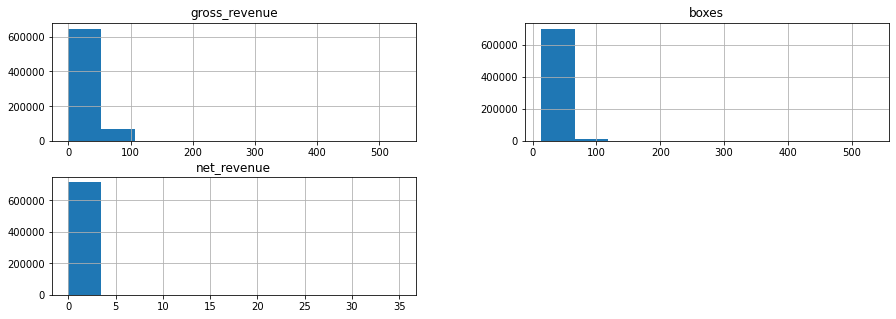

In [26]:
df[['gross_revenue','boxes','net_revenue']].hist(figsize=(15,5));

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="black"><b>Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

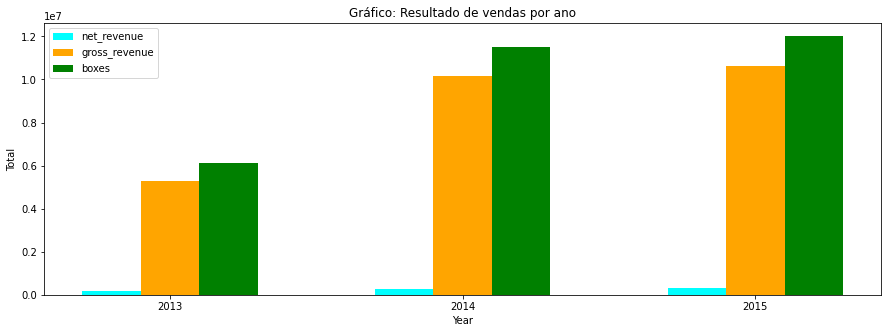

Tabela: Resultado de vendas por ano


,net_revenue,gross_revenue,boxes
year,,,
2013,156281,5295656,6134018
2014,292259,10162118,11505830
2015,292776,10611183,12019122


In [27]:
# data
x = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['year']
y2 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['gross_revenue']
y1 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['net_revenue']
y3 = df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum().reset_index()['boxes']
width = 0.2
 
plt.figure(figsize=(15,5))    
    
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['2013', '2014', '2015'])
plt.xlabel("Year")
plt.ylabel("Total")
plt.legend(["net_revenue", "gross_revenue", "boxes"])
plt.title('Gráfico: Resultado de vendas por ano')
plt.show()


# Tabela
print('Tabela: Resultado de vendas por ano')
df[['year','net_revenue','gross_revenue','boxes']].groupby('year').sum()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="black"><b> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

<b>R: Paid Marketing em 2013 e em 2015. Para isso seperaou-se o faturamento de cada customer_acquisition_channel e calculou-se a média para cada valor categórico dessa classe. Resposta abaixo</b></font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [28]:
# 2013

df.loc[df['year']==2013, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,37.010380
1,Referral,31.170042


In [29]:
# 2015

df.loc[df['year']==2015, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,38.059646
1,Referral,33.201835


https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="grey"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="black"><b>-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

<b>R: Tabela e gráfico no snipet abaixo</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

Tabela:


,year,customer_id
0,2013,35849
1,2014,54864
2,2015,51643


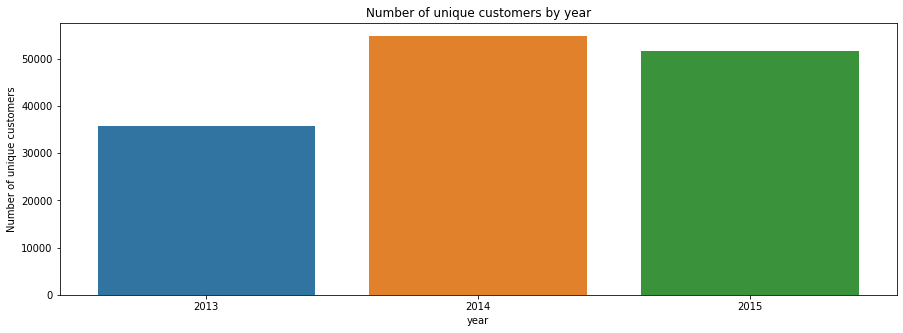

In [30]:
# Gráfico:
plt.figure(figsize=(15,5))
sns.barplot(x='year', y='customer_id', data=df[['customer_id','year']].groupby(['year']).nunique().reset_index())
plt.ylabel('Number of unique customers')
plt.title('Number of unique customers by year')
plt.plot()

# Tabela

# Grouping by year and counting uniques
print('Tabela:')
df[['customer_id','year']].groupby(['year']).nunique().reset_index()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="black"><b>-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<b>R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<b>Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<b>Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</b></font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="black"><b>Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.
    
<b>Para resolver essa demanda todo o passo-a-passo para o desenvolvimento é descrito nas etapas 2.0 Feature engineering, 3.0 Data filtering, 4.0 Exploratory Data Analysis (EDA), 5.0 Data preparation e 6.0 Machine learning   
    
    
 </font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

# 2.0 Feature engineering

In [31]:
df_2 = df.copy()

## <font color="gray"> Semanas do ano </font>

https://www.epochconverter.com/pt/semanas/2015

<b>2013</b>




Janeiro -    semana 1 a 5    -> 1


Fevereiro -  semana 6 - 9    -> 2


Março -      semana 10 - 13  -> 3


Abril -      semana 14 - 18  -> 4


Maio -       semana 19 - 22  -> 5


Junho -      semana 23 - 26  -> 6


Julho -      semana 27 - 31  -> 7


Agosto -     semana 32 - 35  -> 8


Setembro -   semana 36 -40   -> 9


Outubro -    semana 41 - 44  -> 10


Novembro -   semana 45 - 48  -> 11


Dezembro -   semana 49 - 52  -> 12





<b>2014</b>



Janeiro -    semana 1 a 5    -> 1



Fevereiro -  semana 6 - 9    -> 2



Março -      semana 10 - 14  -> 3



 
Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 35  -> 8




Setembro -   semana 36 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 48  -> 11




Dezembro -   semana 49 - 52  -> 12



<b>2015</b>





Janeiro -    semana 1 a 5    -> 1




Fevereiro -  semana 6 - 9    -> 2




Março -      semana 10 - 14  -> 3 




Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 36  -> 8




Setembro -   semana 37 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 49  -> 11




Dezembro -   semana 50 - 53  -> 12

## <font color="gray"> 2.1 Creating new features </font>

In [32]:
# Creating 'semester_of_year' column

df_2['semester_of_year'] =  [1 if i <26 else 2 for i in df['week_of_year']]



# Creating 'month_of_year' column

df_2['month_of_year'] = np.nan


# Filling month of year

# 2013

df_2.loc[df_2['year']==2013, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=13
                                                  else 4 if 14<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=26
                                                  else 7 if 27<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2013, 'week_of_year'] ]


# 2014

df_2.loc[df_2['year']==2014, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2014, 'week_of_year'] ]


# 2015

df_2.loc[df_2['year']==2015, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=36
                                                  else 9 if 37<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=49
                                                  else 12 for i in df_2.loc[df_2['year']==2015, 'week_of_year'] ]


# changing 'month_of_year' data type

df_2['month_of_year'] = df_2['month_of_year'].astype('int')



# Creating 'quarter_of_the_year' column (trimestre)

df_2['quarter'] = [1 if i<= 3
                  else 2 if 4<=i<=6
                  else 3 if 7<=i<=9
                  else 4  for i in df_2['month_of_year']]




# Creating 'week_of_month' column

df_2['week_of_month'] = np.nan


# filling the column:


for i in tuple(df_2['year'].unique()):
    
    for it in tuple(df_2['month_of_year'].unique()):
    
        for count, value in tuple(enumerate(np.sort(df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i), 'week_of_year'].unique()).tolist())):

            df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i) & (df_2['week_of_year']==value), 'week_of_month'] = count+1
            


# changing 'week_of_month' data type

df_2['week_of_month'] = df_2['week_of_month'].astype('int')


In [33]:
df_2.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
gross_revenue                   0
boxes                           0
net_revenue                     0
week_of_year                    0
semester_of_year                0
month_of_year                   0
quarter                         0
week_of_month                   0
dtype: int64

# 3.0 Data filtering

In [34]:
df_3 = df_2.copy()

In [35]:
# Remover as linhas onde 'net_revenue'==0

df_3 = df_3[df_3['net_revenue']!=0]


# Organizar o dataset cronologicamente (importante para problemas de previsão)

df_3 = df_3.sort_values(by=['year','week_of_year'])



# Remover colunas que não estarão em produção ['customer_acquisition_channel', 'gross_revenue', 'boxes'] e
## agrupar o df mantendo a granulometria em cada semana do ano, somando o net_revenue para cada semana

df_grouped = df_3[['year',
                   'month_of_year',
                   'week_of_month',
                   'week_of_year',
                   'quarter',
                   'semester_of_year',
                   'net_revenue']].groupby(['year',
                                            'month_of_year',
                                            'week_of_month',
                                            'week_of_year',
                                            'quarter',
                                            'semester_of_year']).sum().reset_index()

É possível observar abaixo que a redução na granulometria diminuiu significativamente o tamanho do dataset. Isso pode trazer consequências nos resultados dos modelos a serem avaliados. Entretanto o pressuposto assumido neste momento é o de que essa ação é a que faria maior sentido já que não se sabe quais clientes farão compras futuras, não se sabe também quais serão 'customer_acquisition_channel' utilizados em compras futuras. Uma vez que o problema demanda previsão de 'net_revenue' então decideiu-se manter as variáveis que estarão presentes no futuro.

In [36]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


# 4.0 Exploratory Data Analysis (EDA)

In [37]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

<AxesSubplot:>

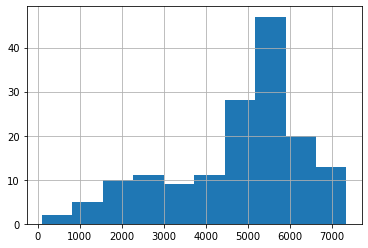

In [38]:
# Response variable

df_grouped['net_revenue'].hist()

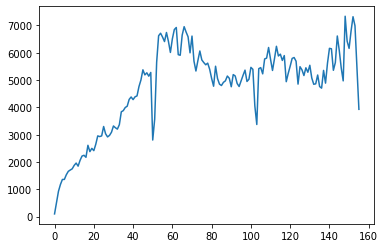

In [39]:
plt.plot(df_grouped['net_revenue'])

In [40]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


### <i>4.1.1 numerical attributes</i>

### <i>4.1.2 categorical attributes</i>

### <i>4.2.1 validating hypothesis raised</i>

## <font color="gray"> 4.2 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

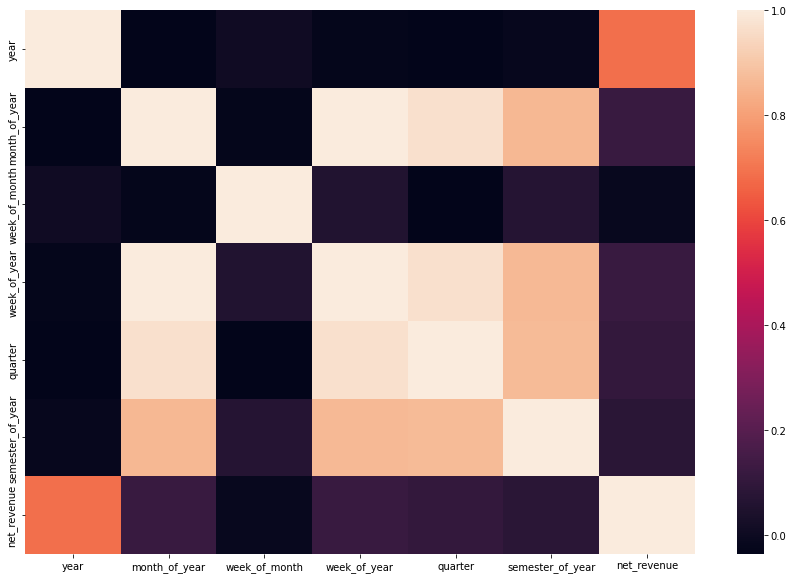

In [41]:
plt.figure(figsize=(15,10))

sns.heatmap(df_grouped.corr());

# 5.0 Data preparation

In [73]:
df_5 = df_grouped.copy()

## <font color="gray"> 5.1 Train/Test split </font>

A separação de treino e teste será feita respeitando a cronologia dos dados. Uma vez que eles já foram organizados na seção anterior então o split treino/teste será feito conforme o enunciado do problema demanda (6 meses futuros). Considerando que a granulometria dos dados ficou em semanas, dessa forma serão separados como conjunto teste as últimas 24 semanas.

In [74]:
df_5

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


In [75]:
# Redefining os index

df_5.index = [i for i in range(0,len(df_5))]


# Uma vez que as variáveis de data já foi desmembrada em novas features, remover a coluna 'year'

df_5 = df_5.drop(columns=['year'])

In [76]:
# Train 

train, test = df_5.iloc[:-24,:], df_5.iloc[-24:,:]

# X
X_train, X_test = train.drop(columns=['net_revenue']), test.drop(columns=['net_revenue'])

# y 
y_train, y_test = train['net_revenue'].copy(), test['net_revenue'].copy()

In [62]:
# Saving X_test to csv

#X_test.to_csv('X_test.csv')

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

As variáveis remanescentes são variáveis de natureza cíclica. Isso deve ser levado em consideração na hora de se fazer o scaling

In [77]:
# month_of_year

X_train['month_of_year_sin'] = X_train['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_train['month_of_year_cos'] = X_train['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_train['month_of_year_sin'] = mms.fit_transform(X_train[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_train['month_of_year_cos'] = mms.fit_transform(X_train[['month_of_year_cos']].values)




# week_of_month

X_train['week_of_month_sin'] = X_train['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['week_of_month_cos'] = X_train['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['week_of_month_sin'] = mms.fit_transform(X_train[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_train['week_of_month_cos'] = mms.fit_transform(X_train[['week_of_month_cos']].values)




# week_of_year

X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_train['week_of_year_sin'] = mms.fit_transform(X_train[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_train['week_of_year_cos'] = mms.fit_transform(X_train[['week_of_year_cos']].values)




# quarter

X_train['quarter_sin'] = X_train['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['quarter_cos'] = X_train['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['quarter_sin'] = mms.fit_transform(X_train[['quarter_sin']].values)

mms = MinMaxScaler()

X_train['quarter_cos'] = mms.fit_transform(X_train[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_train = X_train[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]

A variável 'semester_of_year' será codificada usando dummies:

In [78]:
# 'semester_of_year' - dummies

X_train = pd.get_dummies(data=X_train, columns=['semester_of_year'], prefix=['semester_of_year'])

Fazendo o scaling dos dados de teste:

In [79]:
# month_of_year

X_test['month_of_year_sin'] = X_test['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_test['month_of_year_cos'] = X_test['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_test['month_of_year_sin'] = mms.fit_transform(X_test[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_test['month_of_year_cos'] = mms.fit_transform(X_test[['month_of_year_cos']].values)




# week_of_month

X_test['week_of_month_sin'] = X_test['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['week_of_month_cos'] = X_test['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['week_of_month_sin'] = mms.fit_transform(X_test[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_test['week_of_month_cos'] = mms.fit_transform(X_test[['week_of_month_cos']].values)




# week_of_year

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_test['week_of_year_sin'] = mms.fit_transform(X_test[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_test['week_of_year_cos'] = mms.fit_transform(X_test[['week_of_year_cos']].values)




# quarter

X_test['quarter_sin'] = X_test['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['quarter_cos'] = X_test['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['quarter_sin'] = mms.fit_transform(X_test[['quarter_sin']].values)

mms = MinMaxScaler()

X_test['quarter_cos'] = mms.fit_transform(X_test[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]



# 'semester_of_year' - dummies

X_test = pd.get_dummies(data=X_test, columns=['semester_of_year'], prefix=['semester_of_year'])

O conjunto de teste não tem a variável 'semester_of_year_1' (porque o período se refere ao segundo semestre de 2015. Devemos adicionar a variável e atribuir o valor de 0 a ela no dado de teste.

In [88]:
# adicionando a coluna 'semester_of_year_1' ao conjunto teste

X_test['semester_of_year_1'] = 0


# reorganizando a ordem das colunas
X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin',
                 'week_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
                 'quarter_sin', 'quarter_cos', 'semester_of_year_1',
                 'semester_of_year_2']]

<AxesSubplot:xlabel='week_of_year_cos', ylabel='week_of_year_sin'>

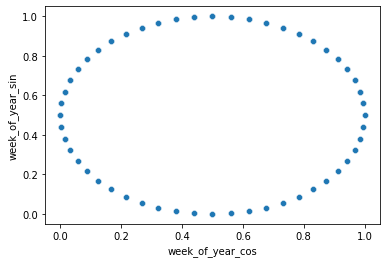

In [84]:
sns.scatterplot(x='week_of_year_cos', y='week_of_year_sin', data=X_train)

# 6.0 Machine learning

In [360]:
list_model_names = []
list_mae = []
list_mape = []
list_rmse = []
list_predictions = []

## <font color="gray"> 6.1 Baseline model </font>

In [361]:

# model definition
dummy_reg = DummyRegressor()

# model fit
dummy_reg.fit(X_train, y_train)

# predictions
y_pred = dummy_reg.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(dummy_reg))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(dummy_reg)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: DummyRegressor()

MAE: 1188.409722222222
MAPE: 0.1928806333457406
RMSE: 1434.9388416319557


## <font color="gray"> 6.2 Linear Regression </font>

In [362]:

# model definition
lr = LinearRegression()

# model fit
lr.fit(X_train, y_train)

# predictions
y_pred = lr.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lr))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lr)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: LinearRegression()

MAE: 1102.845197573453
MAPE: 0.18535787570673015
RMSE: 1268.075097449627


## <font color="gray"> 6.3 Lasso </font>

In [363]:

# model definition
lasso = Lasso()

# model fit
lasso.fit(X_train, y_train)

# predictions
y_pred = lasso.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lasso))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lasso)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: Lasso()

MAE: 1083.1874616274238
MAPE: 0.18098958573751087
RMSE: 1247.3075237144196


## <font color="gray"> 6.4 Random Forest </font>

In [364]:
# model definition
rf = RandomForestRegressor()

# model fit
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(rf))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Random Forest')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: RandomForestRegressor()

MAE: 1366.413523313492
MAPE: 0.22428314442944966
RMSE: 1623.0136906905002


## <font color="gray"> 6.5 XGBoost </font>

In [365]:
# model definition
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9)

# model fit
xg_boost.fit(X_train, y_train)

# predictions
y_pred = xg_boost.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(xg_boost))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('XGBoost')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: XGBRegressor(colsample_bytree=0.9, eta=0.01, max_depth=10,
             objective='reg:squarederror', subsample=0.7)

MAE: 1368.6994730631511
MAPE: 0.22917311763106155
RMSE: 1692.4266809347155


## <font color="gray"> 6.6 Neural Network </font>

In [366]:
# ========================= ANN com LOOCV ===================================================

# ========================= model training =======================================

in_dim = np.array(X_train).shape[1]
out_dim = np.array(y_train.to_frame()).shape[1]



   
# define model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(100, input_dim=in_dim, activation="relu"))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(32, activation="relu"))
# Defining the Ouput layer
model.add(Dense(out_dim))
# Compiling the model
model.compile(loss="mse", optimizer="rmsprop")      

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#predictions
y_pred = model.predict(X_test)
    

# ============================================================================================ 


# Metrics
print('Model metrics: {}\n'.format('Neural Network'))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Neural Network')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 100)               1100      
                                                                 
 dense_19 (Dense)            (None, 32)                3232      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 874us/step - loss: 23491814.0000
Epoch 2/100
11/11 [==============================] - 0s 1ms/step - loss: 23479462.0000
Epoch 3/100
11/11 [==============================] - 0s 884us/step - loss: 23464676.0000
Epoch 4/100
11/11 [==============================] 

11/11 [==============================] - 0s 767us/step - loss: 3436659.5000
Epoch 84/100
11/11 [==============================] - 0s 864us/step - loss: 3430996.0000
Epoch 85/100
11/11 [==============================] - 0s 796us/step - loss: 3418229.5000
Epoch 86/100
11/11 [==============================] - 0s 903us/step - loss: 3407691.2500
Epoch 87/100
11/11 [==============================] - 0s 764us/step - loss: 3396108.7500
Epoch 88/100
11/11 [==============================] - 0s 775us/step - loss: 3390237.0000
Epoch 89/100
11/11 [==============================] - 0s 786us/step - loss: 3378964.2500
Epoch 90/100
11/11 [==============================] - 0s 706us/step - loss: 3370129.5000
Epoch 91/100
11/11 [==============================] - 0s 756us/step - loss: 3364342.0000
Epoch 92/100
11/11 [==============================] - 0s 869us/step - loss: 3357220.0000
Epoch 93/100
11/11 [==============================] - 0s 903us/step - loss: 3348309.0000
Epoch 94/100
11/11 [==============

## <font color="gray"> 7.7 ARIMA </font>

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [367]:
# Dataframe para ARIMA

df_arima_train = pd.DataFrame(y_train)

df_arima_test = pd.DataFrame(y_test)

In [368]:
# Implementando ARIMA

decomposition =  seasonal_decompose(df_arima_train, period=62)

model = ARIMA(df_arima, order=(2,1,2))

results = model.fit()

In [369]:
## Ajuste arima

# results.fittedvalues


# Inserindo as predições no conjunto teste

df_arima_test['predictions'] = results.predict(start=132, end=155)

In [370]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_arima_test['net_revenue'].values,
                                                       df_arima_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('ARIMA')
list_mae.append(mean_absolute_error(y_test, df_arima_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_arima_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_arima_test['predictions'].values, squared=False))

list_predictions.append(df_arima_test['predictions'].values)

MAE: 799.088910034829
MAPE: 0.13166795487607433
RMSE: 1021.7535534089687


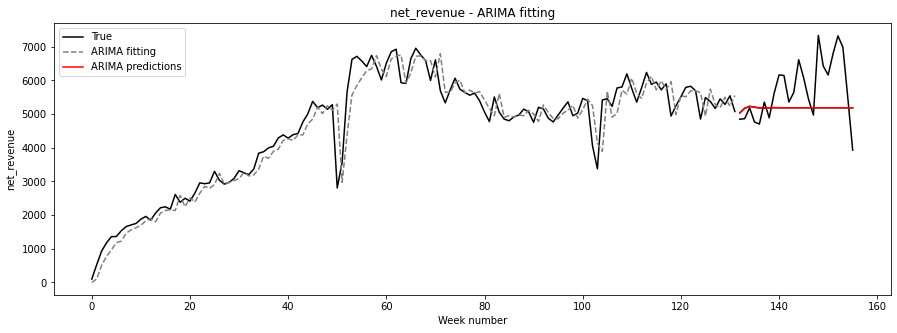

In [371]:
plt.figure(figsize=(15,5))


plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='ARIMA fitting', linestyle="--")
plt.legend()


plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - ARIMA fitting');

## <font color="gray"> 7.8 Exponential Smoothing - HoltWinters </font>

In [372]:
# Dataframe para HW

df_hw_train = pd.DataFrame(y_train)

df_hw_test = pd.DataFrame(y_test)

In [373]:
model = ExponentialSmoothing(df_hw_train, seasonal_periods=26,trend='add', seasonal='add', initialization_method="estimated")

results = model.fit()

In [374]:
## Ajuste HW

results.fittedvalues


# Inserindo as predições no conjunto teste

df_hw_test['predictions'] = results.forecast(len(df_hw_test))

In [375]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_hw_test['net_revenue'].values,
                                           df_hw_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_hw_test['net_revenue'].values,
                                                       df_hw_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_hw_test['net_revenue'].values,
                                           df_hw_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('Exp. Smoothing')
list_mae.append(mean_absolute_error(y_test, df_hw_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_hw_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_hw_test['predictions'].values, squared=False))

list_predictions.append(df_hw_test['predictions'].values)

MAE: 909.8647865581116
MAPE: 0.1459890067151265
RMSE: 1163.9301050464428


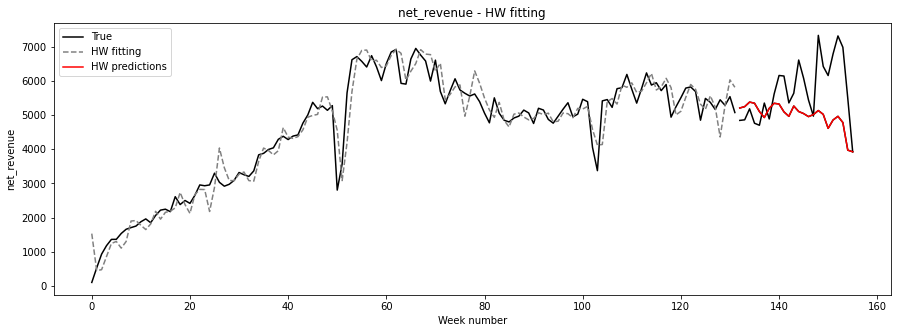

In [376]:
plt.figure(figsize=(15,5))


plt.plot(df_hw_train, color='black', label='True')
plt.plot(df_hw_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='HW fitting', linestyle="--")
plt.legend()


plt.plot(df_hw_test['predictions'], color='red', label='HW predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - HW fitting');

## <font color="gray"> Overall results </font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="black"><b>Qual modelo teve a melhor performance?
    
<font color="black"><b>R: Considerando a métrica MAE (e também MAPE e RMSE) a abordagem que retornou o menor erro no conjunto de teste foi o ARIMA (tabela abaixo).</b></font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [377]:
print('Resultado modelos:')

pd.DataFrame({'MAPE':list_mape, 'MAE':list_mae, 'RMSE':list_rmse}, index=list_model_names).sort_values(by=['MAE'])

Resultado modelos:


,MAPE,MAE,RMSE
ARIMA,0.131668,799.088910,1021.753553
Exp. Smoothing,0.145989,909.864787,1163.930105
Lasso(),0.180990,1083.187462,1247.307524
LinearRegression(),0.185358,1102.845198,1268.075097
DummyRegressor(),0.192881,1188.409722,1434.938842
Random Forest,0.224283,1366.413523,1623.013691
XGBoost,0.229173,1368.699473,1692.426681
Neural Network,0.307996,1692.985982,1874.351050


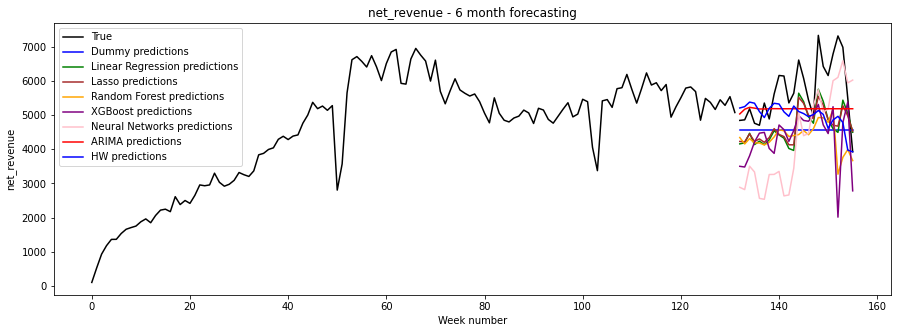

In [383]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()


# Lasso
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Brown', label='Lasso predictions')

plt.legend()


# Random Forest
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()


# XGBoost
plt.plot(pd.DataFrame(list_predictions[4], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Purple', label='XGBoost predictions')

plt.legend()


# Neural Networks
plt.plot(pd.DataFrame(list_predictions[5], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')

plt.legend()


# ARIMA
plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()


# Exp Smooth
plt.plot(df_hw_test['predictions'], color='blue', label='HW predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

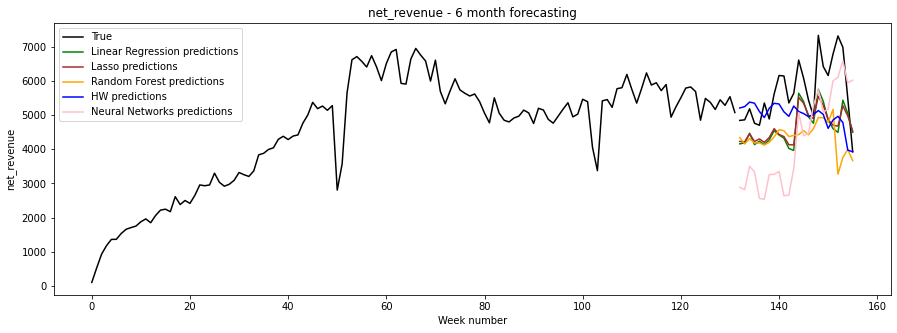

In [384]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()




# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()


# Lasso
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Brown', label='Lasso predictions')

plt.legend()


# Random Forest
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()


# Exp Smooth
plt.plot(df_hw_test['predictions'], color='blue', label='HW predictions')

plt.legend()

# Neural Networks
plt.plot(pd.DataFrame(list_predictions[5], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="grey">Qual modelo teve a melhor performance?

- <font color="grey">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="black"><b>Como realizou treino e teste?</b></font>
    
<font color="black"><b>R: Conforme mencionado anteriormente, por se tratar de um problema de previsão no tempo é importante considerar essa informação na resolução do problema na parte da separação dos respectivos conjuntos de treino e teste. Ambos os conjuntos precisam estar organizados temporalmente onde o conjunto teste deve corresponder ao período futuro em relação ao conjunto de treino. Uma vez que a granulometria usada para resolver o problema estava em semanas e a demanda de previsão era para 6 meses então separou-se as últimas 24 semanas para ser o conjunto teste.</b></font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

# 8.0 Hyperparameter fine tuning

## <font color="gray"> 8.1 Random search </font>

## <font color="gray"> 8.2 Tuned final model </font>

# 9.0 Error interpretation

## <font color="gray"> 9.1 Main </font>

# 10.0 Deploy

## <font color="gray"> 10.1 Class data_prep.py </font>

## <font color="gray"> 10.2 API_handler.py </font>

## <font color="gray"> 10.3 API tester local </font>

## <font color="gray"> 10.4 API tester remote/cloud </font>